# Подгружаем все что может понадобится

In [1]:
import pandas as pd
import numpy as np
import sys
import datetime
import matplotlib.pyplot as plt
from sortedcontainers import SortedDict
import warnings
import math
from copy import deepcopy
from tqdm import tqdm
import matplotlib as mpl
import platform
from collections import Counter
from IPython.core.display import HTML
import os
from copy import deepcopy
import json
from copy import deepcopy
from statistics import median
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.validation.np_iterators import TimeSeriesIterator



warnings.filterwarnings('ignore')
pd.options.display.max_rows = 10000




ModuleNotFoundError: No module named 'lightautoml'

In [2]:
!conda install lightautoml

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - lightautoml

Current channels:

  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




# Посмотрим на наши данные и почистим их

In [4]:
#fol = pd.read_csv("/Users/a185583357/Downloads/MMzip/fol/LKOH.txt", sep=",")

#TODO Inspect 20150923 - lots of errors there
fol = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog20150310/OrderLog20150310.txt", sep=',')
fol["TRADENO"] = fol["TRADENO"].astype(str)
fol.tail()

,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
26214948,26214949,FXIT,S,184457675,12836191,0,2461.0000,11285,nan,NaN
26214949,26214950,OGKB,S,184458220,12805810,0,0.2164,1000,nan,NaN
26214950,26214951,SBER,B,184458269,12819204,0,69.0900,30,nan,NaN
26214951,26214952,VZRZP,S,184458683,6479754,0,91.5000,20,nan,NaN
26214952,26214953,FXGD,S,184459634,12836206,0,519.0000,56500,nan,NaN


In [5]:


count = Counter(fol["SECCODE"]).most_common(30)
out = []
for share in count:
    out.append(share[0])
count

[('GAZP', 2997383),
 ('SBER', 2290044),
 ('SNGS', 2087074),
 ('CHMF', 1425078),
 ('RTKM', 1339749),
 ('LKOH', 1049386),
 ('ROSN', 844480),
 ('SBERP', 738394),
 ('VTBR', 714055),
 ('HYDR', 713783),
 ('SNGSP', 712352),
 ('MGNT', 704247),
 ('TRNFP', 694222),
 ('GMKN', 631399),
 ('NLMK', 593623),
 ('MTSS', 593605),
 ('MTLR', 581235),
 ('MOEX', 551809),
 ('URKA', 468585),
 ('TATN', 459544),
 ('ALRS', 456695),
 ('MAGN', 436832),
 ('EONR', 418226),
 ('FEES', 377768),
 ('AFKS', 366013),
 ('IRAO', 330446),
 ('MVID', 258997),
 ('NVTK', 251434),
 ('OGKB', 191821),
 ('SIBN', 191810)]

In [6]:
fol.head(5)

,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
0,1,ENRU,B,100000000,1,1,0.785,100000,nan,NaN
1,2,SBERP,B,100000000,2,1,52.400,10000,nan,NaN
2,3,AFKS,B,100000000,3,1,15.880,100,nan,NaN
3,4,AFLT,B,100000000,4,1,37.000,100,nan,NaN
4,5,ALRS,S,100000000,5,1,77.000,20000,nan,NaN


#  Соберем стакан из этого

Общая идея взята из статьи - https://habr.com/ru/post/276635/

In [7]:
from sortedcontainers import SortedDict

class DOM:
    def __init__(self):
        self.bid = SortedDict() #descending
        self.ask = SortedDict()
        self.bid_active_order = dict()
        self.ask_active_order = dict()
        self.day = None
        self.flag = None
        
    
    def check_order(self, data):
        if self.day != data["DATE"]:
            self.clean_dom()
            self.day = data["DATE"]
        
        if data["ACTION"] == 1:
            self.check_add(data)
        elif data["ACTION"] == 0:
            self.delete_order(data)
        else:
            self.trade(data)
        
    ## First part - adding order
        
    def check_add(self, data):
        if data["PRICE"] < 0.000000001:
            self.add_order(data)
            pass
        else:
            self.add_order(data)
                
    
    def add_order(self, data):
        if data['BUYSELL'] == "B":
            self.bid_active_order[data["ORDERNO"]] = (data["PRICE"], data["VOLUME"])
            if data["PRICE"] not in self.bid:
                self.bid[data["PRICE"]] = data["VOLUME"]
            else:
                self.bid[data["PRICE"]] += data["VOLUME"]
        else:
            self.ask_active_order[data["ORDERNO"]] = (data["PRICE"], data["VOLUME"])
            if data["PRICE"] not in self.ask:
                self.ask[data["PRICE"]] = data["VOLUME"]
            else:
                self.ask[data["PRICE"]] += data["VOLUME"]
    ## Second part - delete order
    
    def delete_order(self, data):
        if data['BUYSELL'] == "B":
            self.bid[data["PRICE"]] -= self.bid_active_order[data["ORDERNO"]][1]
            del self.bid_active_order[data["ORDERNO"]]
            if self.bid[data["PRICE"]] < 0.000000001:
                del self.bid[data["PRICE"]]
        else:
            self.ask[data["PRICE"]] -= self.ask_active_order[data["ORDERNO"]][1]
            del self.ask_active_order[data["ORDERNO"]]
            if self.ask[data["PRICE"]] < 0.000000001:
                del self.ask[data["PRICE"]]
    
    ## Third part - match order   
    def trade(self, data):
        if data['BUYSELL'] == "B":
            self.exec_buy_order(data)
        else:
            self.exec_sell_order(data)
    

    def exec_sell_order(self, data):
        self.flag = None
        order = self.ask_active_order[data["ORDERNO"]]
        if data["VOLUME"] < order[1]:
            self.ask_active_order[data["ORDERNO"]] = (data["PRICE"], 
                                                      order[1] - data["VOLUME"])
        elif data["VOLUME"] == order[1]:
            del self.ask_active_order[data["ORDERNO"]]
        else:
            #iseberg or error
            #raise Exception(self.ask_active_order[data["ORDERNO"]], data)
            del self.ask_active_order[data["ORDERNO"]]
            self.flag = data["ORDERNO"]
            
        
        if data["PRICE"] not in self.ask:
            raise Exception
            pass
        else:
            self.ask[data["PRICE"]] -= min(order[1], data["VOLUME"])
            if self.ask[data["PRICE"]] < 0.000000001:
                del self.ask[data["PRICE"]]

    
    
    def exec_buy_order(self, data):
        self.flag = None
        order = self.bid_active_order[data["ORDERNO"]]
        if data["VOLUME"] < order[1]:
            self.bid_active_order[data["ORDERNO"]] = (data["PRICE"], 
                                                      order[1] - data["VOLUME"])
        elif data["VOLUME"] == order[1]:
            del self.bid_active_order[data["ORDERNO"]]
        else:
            #iseberg or error
            #raise Exception(self.bid_active_order[data["ORDERNO"]], data)
            del self.bid_active_order[data["ORDERNO"]]
            flag = data["ORDERNO"]
        
        if data["PRICE"] not in self.bid:
            raise Exception(data, self.bid)
            pass
        else:
            self.bid[data["PRICE"]] -= min(order[1], data["VOLUME"])
            if self.bid[data["PRICE"]] < 0.000000001:
                del self.bid[data["PRICE"]]
    
    ## Others
    
        
    def clean_dom(self):
        self.__init__()
        
        

In [11]:
date = "20150310"
data = fol[fol["SECCODE"] == "SBER"]
data = data[data["ACTION"] != 2]
data["DATE"] = date
records = data.to_dict("records")
data.reset_index(inplace=True)
data.shape

(2115840, 12)

In [12]:
dom = DOM()
errors = 0
isebergs = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs" + date + ".csv", index_col=0).to_dict()["vol"]

for i in tqdm(range(len(records))):
    record = records[i].copy()
    if record["ACTION"] == 1 and record["ORDERNO"] in isebergs:
        record["VOLUME"] = isebergs[record["ORDERNO"]]
    try:
        out = dom.check_order(record)
    except Exception as e:
        print(e)
        if record["ACTION"] == 1:
            print("MAYBE Some problem, cant add order")
            dom.check_order(record)
            raise Exception
        errors += 1

100%|██████████| 2115840/2115840 [00:05<00:00, 382489.00it/s]


# Создадим стакан способный сам матчить все заявки и сравним с оригиналом

In [13]:
date = "20150310"
data = fol[fol["SECCODE"] == "SBER"]
data = data[data["ACTION"] != 2]
data["DATE"] = date
records = data.to_dict("records")
data.reset_index(inplace=True)
data.shape

(2115840, 12)

In [14]:
data.head()

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE,DATE
0,47,48,SBER,B,100000000,48,1,70.00,20,nan,NaN,20150310
1,49,50,SBER,B,100000000,50,1,70.50,880,nan,NaN,20150310
2,94,95,SBER,B,100000000,95,1,72.45,15000,nan,NaN,20150310
3,138,139,SBER,B,100000000,139,1,72.23,10700,nan,NaN,20150310
4,147,148,SBER,B,100000000,148,1,71.00,100,nan,NaN,20150310


In [15]:
class Matching_Engine:
    def __init__(self):
        self.bid = SortedDict()  # descending
        self.ask = SortedDict()
        self.bid_active_order = dict()
        self.ask_active_order = dict()
        self.bid_FIFO = dict()
        self.ask_FIFO = dict()
        self.day = None
        self.share_name = "LKOH"
        self.trade_log = []

    def check_order(self, data):
        if self.day != data["DATE"]:
            self.clean_dom()
            self.share_name = data["SECCODE"]
            self.day = data["DATE"]

        if data["ACTION"] == 1:
            return self.check_add(data, new_trades=[])
        elif data["ACTION"] == 2:
            pass
        else:
            self.delete_order(data)

    ## First part - adding order

    def check_add(self, data, rec_flag=False, new_trades=[]):
        if (len(self.ask) > 0 and data['BUYSELL'] == "B" and \
            (data["PRICE"] >= self.ask.peekitem(0)[0] or data["PRICE"] < 0.000001)) or \
                (len(self.bid) > 0 and data['BUYSELL'] == "S" and data["PRICE"] <= self.bid.peekitem(-1)[0]):
            if not rec_flag:
                self.add_order(data)
            return self.trade(data, new_trades=new_trades)
        else:
            if not rec_flag:
                self.add_order(data)

    def add_order(self, data):
        if data['BUYSELL'] == "B":
            self.bid_active_order[data["ORDERNO"]] = (data["PRICE"], data["VOLUME"])
            if data["PRICE"] not in self.bid:
                self.bid[data["PRICE"]] = data["VOLUME"]
                self.bid_FIFO[data["PRICE"]] = [data["ORDERNO"]]
            else:
                self.bid[data["PRICE"]] += data["VOLUME"]
                self.bid_FIFO[data["PRICE"]].append(data["ORDERNO"])
        else:
            self.ask_active_order[data["ORDERNO"]] = (data["PRICE"], data["VOLUME"])
            if data["PRICE"] not in self.ask:
                self.ask[data["PRICE"]] = data["VOLUME"]
                self.ask_FIFO[data["PRICE"]] = [data["ORDERNO"]]
            else:
                self.ask[data["PRICE"]] += data["VOLUME"]
                self.ask_FIFO[data["PRICE"]].append(data["ORDERNO"])

    ## Second part - delete order

    def delete_order(self, data):
        if data['BUYSELL'] == "B":
            self.bid_FIFO[data["PRICE"]].pop(self.bid_FIFO[data["PRICE"]].index(data["ORDERNO"]))
            self.bid[data["PRICE"]] -= self.bid_active_order[data["ORDERNO"]][1]
            if len(self.bid_FIFO[data["PRICE"]]) < 1:
                del self.bid_FIFO[data["PRICE"]]
            del self.bid_active_order[data["ORDERNO"]]
            if self.bid[data["PRICE"]] < 0.000000001:
                del self.bid[data["PRICE"]]
        else:
            self.ask[data["PRICE"]] -= self.ask_active_order[data["ORDERNO"]][1]
            self.ask_FIFO[data["PRICE"]].pop(self.ask_FIFO[data["PRICE"]].index(data["ORDERNO"]))
            if len(self.ask_FIFO[data["PRICE"]]) < 1:
                del self.ask_FIFO[data["PRICE"]]
            del self.ask_active_order[data["ORDERNO"]]
            if self.ask[data["PRICE"]] < 0.000000001:
                del self.ask[data["PRICE"]]

    ## Third part - match order
    def trade(self, data, new_trades=[]):
        if data['BUYSELL'] == "B":
            return self.exec_buy_order(data, new_trades=new_trades)
        else:
            return self.exec_sell_order(data, new_trades=new_trades)

    def exec_sell_order(self, data, new_trades=[]):
        go_trade= True
        while go_trade:
            go_trade = False
            sell_order = self.ask_active_order[data["ORDERNO"]]
            tradeprice = self.bid.peekitem(-1)[0]
            order_no = self.bid_FIFO[tradeprice][0]
            if str(order_no)[0] == 'm':
                out_no = "mm_past"
            else:
                out_no = order_no
            buy_order = self.bid_active_order[order_no]
            if buy_order[1] > sell_order[1]:
                self.bid_active_order[order_no] = (self.bid_active_order[order_no][0],
                                                   buy_order[1] - sell_order[1])
                trade_vol = sell_order[1]
                self.bid[buy_order[0]] -= trade_vol
                self.delete_order(data)
            elif buy_order[1] == sell_order[1]:
                self.delete_order(data)
                tmp = dict()
                tmp["BUYSELL"] = "B"

                tmp["PRICE"] = buy_order[0]
                tmp["ORDERNO"] = order_no

                self.delete_order(tmp)
                trade_vol = sell_order[1]
            else:
                # iseberg or error
                tmp = dict()
                tmp["BUYSELL"] = "B"
                tmp["PRICE"] = buy_order[0]
                tmp["ORDERNO"] = order_no
                self.delete_order(tmp)
                trade_vol = buy_order[1]
                self.ask[sell_order[0]] -= trade_vol
                self.ask_active_order[data["ORDERNO"]] = (self.ask_active_order[data["ORDERNO"]][0],
                                                          sell_order[1] - buy_order[1])
                # TODO не учтено полное пробитие стакана!!
                if self.bid.peekitem(-1)[0] >= sell_order[0] or data["PRICE"] < 0.000000001:
                    go_trade = True

            self.trade_log.append(
                [tradeprice, trade_vol, data["ORDERNO"], out_no, tradeprice * trade_vol, data["TIME"], data["NO"], "S"])
            new_trades.append(self.trade_log[-1])
            if buy_order[1] < 0 or sell_order[1] < 0:
                raise Exception(buy_order, sell_order)
            if go_trade:
                data["VOLUME"] -= trade_vol
                self.ask_active_order[data["ORDERNO"]] = (self.ask_active_order[data["ORDERNO"]][0], data["VOLUME"])
                # self.ask[data["PRICE"]] -= data["VOLUME"]
                #return self.check_add(data, rec_flag=True, new_trades=new_trades)
        return new_trades

    def exec_buy_order(self, data, new_trades=[]):
        go_trade = True
        while go_trade:
            go_trade = False
            buy_order = self.bid_active_order[data["ORDERNO"]]
            tradeprice = self.ask.peekitem(0)[0]
            order_no = self.ask_FIFO[tradeprice][0]
            if str(order_no)[0] == 'm':
                out_no = "mm_past"
            else:
                out_no = order_no
            sell_order = self.ask_active_order[order_no]
            if sell_order[1] > buy_order[1]:
                self.ask_active_order[order_no] = (self.ask_active_order[order_no][0],
                                                   sell_order[1] - buy_order[1])
                trade_vol = buy_order[1]
                self.ask[sell_order[0]] -= trade_vol
                self.delete_order(data)
            elif buy_order[1] == sell_order[1]:
                self.delete_order(data)
                tmp = dict()
                tmp["BUYSELL"] = "S"
                tmp["PRICE"] = sell_order[0]
                tmp["ORDERNO"] = self.ask_FIFO[tradeprice][0]
                self.delete_order(tmp)
                trade_vol = sell_order[1]
            else:
                # iseberg or error
                tmp = dict()
                tmp["BUYSELL"] = "S"
                tmp["PRICE"] = sell_order[0]
                tmp["ORDERNO"] = order_no
                self.delete_order(tmp)
                trade_vol = sell_order[1]
                self.bid[buy_order[0]] -= trade_vol
                self.bid_active_order[data["ORDERNO"]] = (self.bid_active_order[data["ORDERNO"]][0],
                                                          buy_order[1] - sell_order[1])
                if self.ask.peekitem(0)[0] <= buy_order[0] or data["PRICE"] < 0.000000001:
                    go_trade = True

            # TODO Мне кажется здесь потенциальная ошибка, не предусмотрено что аркет мейкер заявка может в кого то удариться
            self.trade_log.append(
                [tradeprice, trade_vol, data["ORDERNO"], out_no, tradeprice * trade_vol, data["TIME"], data["NO"], "B"])
            new_trades.append(self.trade_log[-1])
            if buy_order[1] < 0 or sell_order[1] < 0:
                raise Exception(buy_order, sell_order)
            if go_trade:
                data["VOLUME"] -= trade_vol
                self.bid_active_order[data["ORDERNO"]] = (self.bid_active_order[data["ORDERNO"]][0], data["VOLUME"])
                # self.bid[data["PRICE"]] -= data["VOLUME"]
                return self.check_add(data, rec_flag=True, new_trades=new_trades)
        return new_trades

    ## Others

    def clean_dom(self):
        self.__init__()



In [16]:
dom = Matching_Engine()
errors = 0
isebergs = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs" + date + ".csv", index_col=0).to_dict()["vol"]

for i in tqdm(range(len(records))):
    record = records[i].copy()
    if record["ACTION"] == 1 and record["ORDERNO"] in isebergs:
        record["VOLUME"] = isebergs[record["ORDERNO"]]
    try:
        out = dom.check_order(record)
    except Exception as e:
        #print(e)
        if record["ACTION"] == 1:
            print("MAYBE Some problem, cant add order")
            dom.check_order(record)
            raise Exception
        errors += 1

100%|██████████| 2115840/2115840 [00:08<00:00, 249438.76it/s]


In [17]:
dom.trade_log[-1]

[69.97, 100, 12836092, 12836086, 6997.0, 183958906, 26213007, 'B']

# Теперь сделаем заготовку для ML, для этого соберем numpy array снапшота стакана и последих трейдов

In [173]:
deep = 1

In [174]:
def RSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = deepcopy(0 * diff)
    down_chg = deepcopy(0 * diff)
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
   
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    
    up_chg_avg   = up_chg.mean()
    down_chg_avg = down_chg.mean()
    
    if down_chg_avg == 0:
        return 100.0
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [175]:
sma5, sma10, sma30, sma50, sma100 = 0, 0, 0, 0, 0
ema5, ema10, ema30, ema100 = 0, 0, 0, 0
std10, std50, std100, std1000 = 0, 0, 0, 0
rsi14, rsi50, rsi100, rsi300 = 0, 0, 0, 0


def get_technical_indicator(change, trade_log, output):
    #TODO это однозначно можно сделать оптимальнее!!
    global deep
    global sma5, sma10, sma30, sma50, sma100
    global ema5, ema10, ema30, ema100
    global std10, std50, std100, std1000 
    global rsi14, rsi50, rsi100, rsi300
    if change != 0:        
        sma5 = np.array(trade_log[-5:])[:, 0].astype(float).mean()
        sma10 = np.array(trade_log[-10:])[:, 0].astype(float).mean()
        sma30 = np.array(trade_log[-30:])[:, 0].astype(float).mean()
        sma50 = np.array(trade_log[-50:])[:, 0].astype(float).mean()
        sma100 = np.array(trade_log[-100:])[:, 0].astype(float).mean()
        #EMA
        ema5 = pd.DataFrame(np.array(trade_log[-5:])[:, 0].astype(float)).ewm(span=5).mean().iat[-1, 0]
        ema10 = pd.DataFrame(np.array(trade_log[-10:])[:, 0].astype(float)).ewm(span=10).mean().iat[-1, 0]
        ema30 = pd.DataFrame(np.array(trade_log[-30:])[:, 0].astype(float)).ewm(span=30).mean().iat[-1, 0]
        ema100 = pd.DataFrame(np.array(trade_log[-100:])[:, 0].astype(float)).ewm(span=30).mean().iat[-1, 0]
        #std
        std10 = np.array(trade_log[-10:])[:, 0].astype(float).std()
        std50 = np.array(trade_log[-50:])[:, 0].astype(float).std()
        std100 = np.array(trade_log[-100:])[:, 0].astype(float).std()
        std1000 = np.array(trade_log[-1000:])[:, 0].astype(float).std()
        #RSI
        rsi14 = RSI(pd.Series(np.array(trade_log[-14:])[:, 0].astype(float)), 14)
        rsi50 = RSI(pd.Series(np.array(trade_log[-50:])[:, 0].astype(float)), 50)
        rsi100 = RSI(pd.Series(np.array(trade_log[-100:])[:, 0].astype(float)), 100)
        rsi300 = RSI(pd.Series(np.array(trade_log[-300:])[:, 0].astype(float)), 300)
    output[deep * 4 + 7] = sma5
    output[deep * 4 + 8] = sma10
    output[deep * 4 + 9] = sma30
    output[deep * 4 + 10] = sma50
    output[deep * 4 + 11] = sma100
    #EMA
    output[deep * 4 + 12] = ema5
    output[deep * 4 + 13] = ema10
    output[deep * 4 + 14] = ema30
    output[deep * 4 + 15] = ema100
    #std
    output[deep * 4 + 16] = std10
    output[deep * 4 + 17] = std50
    output[deep * 4 + 18] = std100
    output[deep * 4 + 19] = std1000
    #RSI
    output[deep * 4 + 20] = rsi14
    output[deep * 4 + 21] = rsi50
    output[deep * 4 + 22] = rsi100
    output[deep * 4 + 23] = rsi300
    return output

In [176]:
def construct_raw(dom, deep, raw_data, record):
    output = [0] * (deep * 4 + 24)
    trade_log = dom.trade_log
    bids = list(dom.bid.items())
    asks = list(dom.ask.items())
    for i in range(0, deep):
        if len(bids) > i:
            #print(bids[-1], i)
            output[(2 * deep) - 2 * i - 1] = bids[-i - 1][1]
            output[(2 * deep) - 2 * i - 2] = bids[-i - 1][0]
        if len(asks) > i:
            #print(asks, i)
            output[(2 * deep) + 2 * i + 1] = asks[i][1]
            output[(2 * deep) + 2 * i] = asks[i][0]
    if len(dom.trade_log) > 0:
        #print(dom.trade_log[-1])
        output[deep * 4] = dom.trade_log[-1][0]
        output[deep * 4 + 1] = dom.trade_log[-1][1]
        if output[deep * 4 + 2] == "B":
            output[deep * 4 + 2] = -1
        else:
            output[deep * 4 + 2] = 1
        change = raw_data[-1][deep * 4] - output[deep * 4]
        if change == 0:
            output[deep * 4 + 3] = 0
        elif change > 0:
            output[deep * 4 + 3] = -1
        else:
            output[deep * 4 + 3] = 1
            
        output[deep * 4 + 4] = dom.trade_log[-1][-3]
    output[deep * 4 + 5] = int(record["DATE"])
    output[deep * 4 + 6] = record["TIME"]
    if len(trade_log) > 50:
        output = get_technical_indicator(change, trade_log, output)
    
    
    return output

In [178]:
def get_data(date, records, deep):
    dom = Matching_Engine()
    errors = 0
    isebergs = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs" + date + ".csv", index_col=0).to_dict()["vol"]
    raw_data = []

    for i in tqdm(range(len(records))):
        record = records[i].copy()
        if record["ACTION"] == 1 and record["ORDERNO"] in isebergs:
            record["VOLUME"] = isebergs[record["ORDERNO"]]
        try:
            out = dom.check_order(record)
            raw_data.append(construct_raw(dom, deep, raw_data, record))
        except Exception as e:
            #print(e)
            if record["ACTION"] == 1:
                print("MAYBE Some problem, cant add order")
                dom.check_order(record)
                raise Exception
            errors += 1
    return raw_data


raw_data = get_data(date, records, deep)
#raw_data[1000]

100%|██████████| 2115840/2115840 [14:23<00:00, 2448.92it/s] 


In [188]:
def get_df_y(raw_data, deep):
    columns = []
    for col in ["Bid", "Ask"]:
        for num in range(1, 1 + deep):
            if col == "Bid":
                num = deep - num + 1
            columns.append(col + "Price" + str(num))
            columns.append(col + "Volume" + str(num))
    dupl_col = deepcopy(columns)
    columns += ["Last Trade Price"] + ["Last Trade Volume"] + ["Side"] + ["isNewTrade"] + \
    ["LastDealTime"] + ["Date"] + ["Time"] + ["SMA5"] + ["SMA10"] + ["SMA30"] + ["SMA50"] + ["SMA100"] +\
    ["EMA5"] + ["EMA10"] + ["EMA30"] + ["EMA100"] + ["STD10"] + ["STD50"] + ["STD100"] + ["STD1000"] +\
    ["RSI14"] + ["RSI50"] + ["RSI100"] + ["RSI300"] 
    snapschot = pd.DataFrame(np.stack(raw_data, axis=0), columns=columns)
    snapschot["LiquidityBid"] = 0
    snapschot["LiquidityAsk"] = 0
    for i in range(1, 1 + deep):
        snapschot['LiquidityAsk'] += snapschot["AskVolume" + str(i)]
        snapschot["LiquidityBid"] += snapschot["BidVolume" + str(i)]

    snapschot["BidLiquidityRatio"] = snapschot["LiquidityBid"] / (snapschot["LiquidityBid"] + snapschot["LiquidityAsk"])
    snapschot = snapschot[snapschot["Time"] > 100002000.0]
    snapschot.drop_duplicates(subset=dupl_col,inplace=True)
    y = np.array(snapschot["isNewTrade"])
    df = snapschot.drop(["isNewTrade"], axis=1)
    return np.array(df), np.array(y), snapschot

df, y, snapschot = get_df_y(raw_data, deep)
y
snapschot.to_csv("SBER20150310.csv")

## Attention надо обязательно сделать задержку и смещение

Данные готовы, по одному дню сбера. теперь посмотрим на них

## Здесь будут графики и анализ существующих данных

In [189]:
visu_data = snapschot#[1500:]

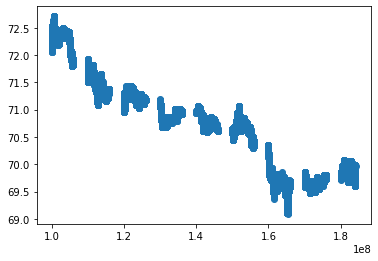

In [190]:
plt.scatter(visu_data["Time"], visu_data["Last Trade Price"])

In [191]:
snapschot

,BidPrice1,BidVolume1,AskPrice1,AskVolume1,Last Trade Price,Last Trade Volume,Side,isNewTrade,LastDealTime,Date,...,STD50,STD100,STD1000,RSI14,RSI50,RSI100,RSI300,LiquidityBid,LiquidityAsk,BidLiquidityRatio
1536,72.50,150.0,72.52,580.0,72.52,1020.0,1.0,0.0,100001843.0,20150310.0,...,0.025147,0.019348,0.020536,50.000000,50.961538,50.769231,50.793651,150.0,580.0,0.205479
1543,72.47,1000.0,72.50,520.0,72.50,50.0,1.0,-1.0,100002115.0,20150310.0,...,0.025976,0.019985,0.020858,70.000000,48.936170,50.000000,50.261780,1000.0,520.0,0.657895
1544,72.52,440.0,72.53,9470.0,72.52,580.0,1.0,1.0,100002115.0,20150310.0,...,0.025976,0.020102,0.020830,50.000000,53.932584,50.806452,50.777202,440.0,9470.0,0.044400
1547,72.52,440.0,72.53,14450.0,72.52,580.0,1.0,0.0,100002115.0,20150310.0,...,0.025976,0.020102,0.020830,50.000000,53.932584,50.806452,50.777202,440.0,14450.0,0.029550
1548,72.52,260.0,72.53,14450.0,72.52,180.0,1.0,0.0,100002134.0,20150310.0,...,0.025976,0.020102,0.020830,50.000000,53.932584,50.806452,50.777202,260.0,14450.0,0.017675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114422,69.89,1980.0,69.98,151570.0,69.97,1370.0,1.0,1.0,183958806.0,20150310.0,...,0.040130,0.044655,0.087060,55.405405,50.000000,50.943396,50.400000,1980.0,151570.0,0.012895
2114423,69.89,1980.0,69.97,1270.0,69.97,1370.0,1.0,0.0,183958806.0,20150310.0,...,0.040130,0.044655,0.087060,55.405405,50.000000,50.943396,50.400000,1980.0,1270.0,0.609231
2114425,69.89,1980.0,69.97,3210.0,69.97,1370.0,1.0,0.0,183958806.0,20150310.0,...,0.040130,0.044655,0.087060,55.405405,50.000000,50.943396,50.400000,1980.0,3210.0,0.381503
2114426,69.89,1980.0,69.97,1840.0,69.97,100.0,1.0,0.0,183958906.0,20150310.0,...,0.040130,0.044655,0.087060,55.405405,50.000000,50.943396,50.400000,1980.0,1840.0,0.518325


,BidPrice5,BidVolume5,BidPrice4,BidVolume4,BidPrice3,BidVolume3,BidPrice2,BidVolume2,BidPrice1,BidVolume1,...,STD50,STD100,STD1000,RSI14,RSI50,RSI100,RSI300,LiquidityBid,LiquidityAsk,BidLiquidityRatio
1536,72.42,40.0,72.44,1000.0,72.45,1480.0,72.46,1000.0,72.50,150.0,...,0.025147,0.019348,0.020536,50.000000,50.961538,50.769231,50.793651,3670.0,31250.0,0.105097
1537,72.44,1000.0,72.45,1480.0,72.46,1000.0,72.47,1000.0,72.50,150.0,...,0.025147,0.019348,0.020536,50.000000,50.961538,50.769231,50.793651,4630.0,31250.0,0.129041
1538,72.45,1480.0,72.46,1000.0,72.47,1000.0,72.48,1000.0,72.50,150.0,...,0.025147,0.019348,0.020536,50.000000,50.961538,50.769231,50.793651,4630.0,31250.0,0.129041
1539,72.44,1000.0,72.45,1480.0,72.46,1000.0,72.47,1000.0,72.50,150.0,...,0.025147,0.019348,0.020536,50.000000,50.961538,50.769231,50.793651,4630.0,31250.0,0.129041
1540,72.44,1000.0,72.45,1480.0,72.46,1000.0,72.47,1000.0,72.50,150.0,...,0.025147,0.019348,0.020536,50.000000,50.961538,50.769231,50.793651,4630.0,31250.0,0.129041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114558,69.53,2560.0,69.60,340.0,69.80,905630.0,69.81,300.0,69.89,1980.0,...,0.040130,0.044655,0.087060,55.405405,50.000000,50.943396,50.400000,910810.0,34720.0,0.963280
2114559,69.53,2560.0,69.60,340.0,69.80,905630.0,69.81,300.0,69.89,1980.0,...,0.040130,0.044655,0.087060,55.405405,50.000000,50.943396,50.400000,910810.0,34720.0,0.963280
2114560,69.53,2560.0,69.60,340.0,69.80,905630.0,69.81,300.0,69.89,1980.0,...,0.040130,0.044655,0.087060,55.405405,50.000000,50.943396,50.400000,910810.0,34720.0,0.963280
2114561,69.53,2560.0,69.60,340.0,69.80,905630.0,69.81,300.0,69.89,1980.0,...,0.040130,0.044655,0.087060,55.405405,50.000000,50.943396,50.400000,910810.0,34720.0,0.963280


In [193]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(3) # мало сплитов потому что по некоторым спутникам слишком мало наблюдений
for train_index, test_index in tscv.split(df):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = df[train_index], df[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [    0     1     2 ... 30646 30647 30648] TEST: [30649 30650 30651 ... 61292 61293 61294]
TRAIN: [    0     1     2 ... 61292 61293 61294] TEST: [61295 61296 61297 ... 91938 91939 91940]
TRAIN: [    0     1     2 ... 91938 91939 91940] TEST: [ 91941  91942  91943 ... 122584 122585 122586]


In [194]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [195]:
Counter(model.predict(X_test))

Counter({0.0: 29371, -1.0: 1135, 1.0: 140})